In [1]:
!pip install livelossplot efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, GlobalMaxPooling2D,Dropout,Conv2D,BatchNormalization,MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn
import tensorflow as tf
import numpy as np

In [14]:
TRAINING_LOGS_FILE = "training_log7.csv"
MODEL_SUMMARY_FILE = "model7_summary.txt"
MODEL_FILE = "model_w_7.keras"
MODEL = "model_7.keras"

In [15]:
# Hyperparams
IMAGE_SIZE = 300
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 128
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)

In [16]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             preprocessing_function=lambda x: np.repeat(x, 3, axis=-1) if x.shape[-1] == 1 else x)
validation_data_generator = ImageDataGenerator(rescale=1./255,
                                               preprocessing_function=lambda x: np.repeat(x, 3, axis=-1) if x.shape[-1] == 1 else x)

In [17]:

model = Sequential()
efficient_net = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300,300,3))

for index, layer in enumerate(efficient_net.layers):
    if index < 799:
        layer.trainable = False

model.add(efficient_net)

# Add additional layers to enhance model efficiency
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.25))  # Adding dropout layer
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))  # Adding dropout layer
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))  # Adding dropout layer
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

In [19]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    "/content/drive/MyDrive/PCOS_AUGMENTED/training",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    "/content/drive/MyDrive/PCOS_AUGMENTED/validation",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")

Found 4845 images belonging to 2 classes.
Found 2078 images belonging to 2 classes.


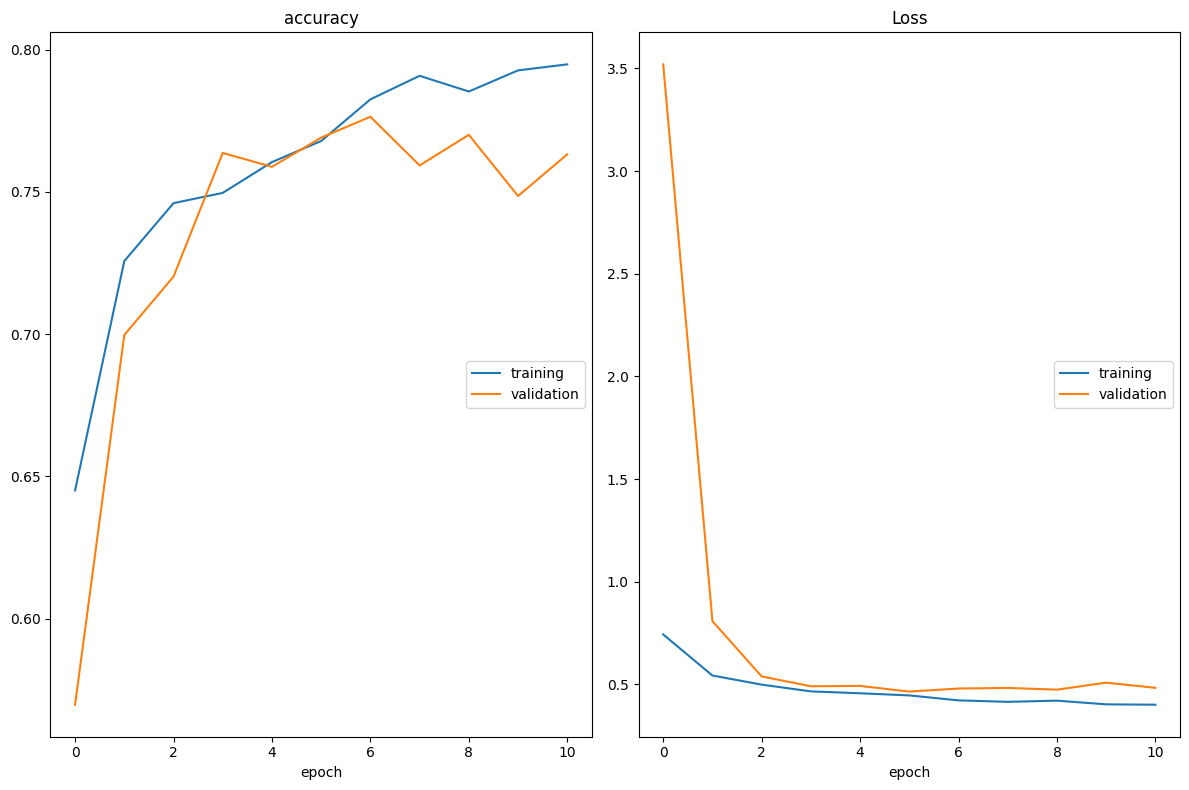

accuracy
	training         	 (min:    0.645, max:    0.795, cur:    0.795)
	validation       	 (min:    0.570, max:    0.776, cur:    0.763)
Loss
	training         	 (min:    0.401, max:    0.743, cur:    0.401)
	validation       	 (min:    0.465, max:    3.520, cur:    0.483)
37/37 [==============================] - 46s 1s/step - loss: 0.4008 - accuracy: 0.7948 - val_loss: 0.4830 - val_accuracy: 0.7632


In [20]:
# # Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# # Learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,append=False,separator=";"),early_stopping],verbose=1)
model.save_weights(MODEL_FILE)
model.save(MODEL)

In [12]:
loss, accuracy = model.evaluate(validation_generator)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

17/17 [==============================] - 17s 992ms/step - loss: 0.4555 - accuracy: 0.7806
Validation loss: 0.45545822381973267
Validation accuracy: 0.7805582284927368


In [13]:
loss, accuracy = model.evaluate(training_generator)
print('training loss:', loss)
print('training accuracy:', accuracy)

38/38 [==============================] - 38s 998ms/step - loss: 0.3904 - accuracy: 0.8027
training loss: 0.3904366195201874
training accuracy: 0.8026831746101379
